# Reconstruction with real data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate_z0
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import ab_initio
import jax

import mrcfile

plt.rcParams["figure.figsize"]=8,8

### Read the data

In [3]:
#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
#star_file = "job550_particles_subsamp5_10000_30_40_2.star"
#star_file = "job550_particles_roy40k.star"
#star_file = "job550_particles.star"


#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/Frost/eIF2B/job042/"
#star_file = "AUG11_99Kparticles_updatedGCTF.star"

#data_dir = "/project/lederman/rrl28/share/CryoEMDataSmall/RelionSample/relion30_tutorial_precalculated_results/"
#star_file = "Extract/job020/particles.star"

data_dir = "/gpfs/gibbs/pi/lederman/dge5/RELION_TUTORIAL_SET/PrecalculatedResults/"
star_file = "/Extract/job018/particles.star"

params0, imgs_f0 = load_data(data_dir, star_file, True)
ctf_params0 = params0["ctf_params"]
pixel_size0 = params0["pixel_size"]
angles0 = params0["angles"]
shifts0 = params0["shifts"]


/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles:  4501
load_data: data loaded, time:  5.135871887207031
load_data: FFT of data, time:  8.209546089172363


In [4]:
print(imgs_f0.shape)
print(pixel_size0.shape)
print(angles0.shape)
print(shifts0.shape)
print(ctf_params0.shape)

#plt.imshow(np.abs(jnp.fft.fftshift(imgs_f0[101]))); plt.colorbar()

(4501, 256, 256)
(4501,)
(4501, 3)
(4501, 2)
(4501, 9)


### Only keep the first N points (to avoid out of memory error)

In [5]:
N = 10000
imgs_f = imgs_f0[:N]
pixel_size = pixel_size0[:N]
angles = angles0[:N]
shifts = shifts0[:N]
ctf_params = ctf_params0[:N]

### Some angle filtering

In [6]:
#idx = jnp.abs(angles0[:,2]) < jnp.pi/4
#imgs_f = imgs_f0[idx]
#pixel_size = pixel_size0[idx]
#angles = angles0[idx]
#shifts = shifts0[idx]
#ctf_params = ctf_params0[idx]

#idx2 = jnp.abs(angles[:,1]) < jnp.pi/3
#imgs_f = imgs_f[idx2]
#pixel_size = pixel_size[idx2]
#angles = angles[idx2]
#shifts = shifts[idx2]
#ctf_params = ctf_params[idx2]

#plot_angles(angles)

### Create the grids

In [7]:
# Assume the pixel size is the same for all images
nx = imgs_f.shape[-1]
px = pixel_size[0]
N = imgs_f.shape[0]

x_grid = create_grid(nx, px)
y_grid = x_grid
z_grid = x_grid
print(x_grid)

[3.13873258e-03 2.56000000e+02]


### Crop images to 32 x 32 

In [8]:
nx = 32
imgs_f, x_grid = crop_fourier_images(imgs_f, x_grid, nx)

y_grid = x_grid
z_grid = x_grid
print(x_grid)

[3.13873258e-03 3.20000000e+01]


### Before further processing, vectorize the images, create mask etc

In [9]:
imgs_f = imgs_f.reshape(N, -1)
print(imgs_f.shape)

(4501, 1024)


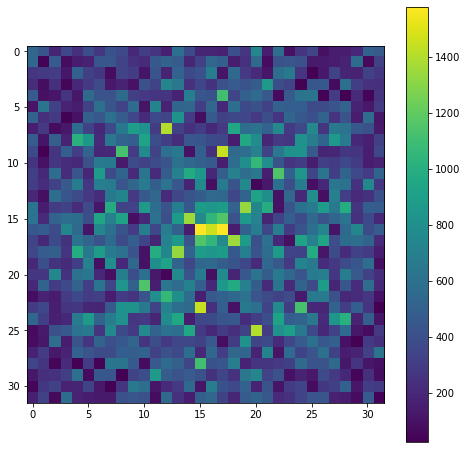

In [10]:
plt.imshow(jnp.abs(jnp.fft.fftshift(jnp.array(imgs_f[101].reshape(nx,nx)))));plt.colorbar()

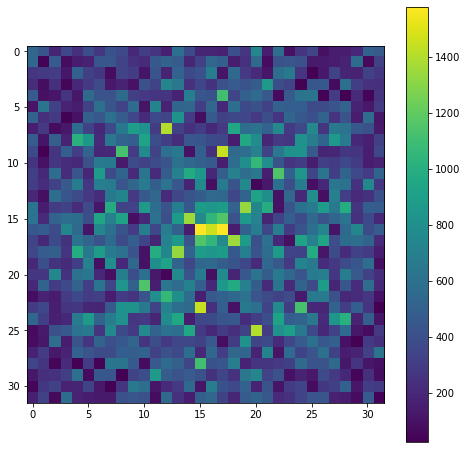

In [11]:
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[101].reshape(nx,nx)))); plt.colorbar()

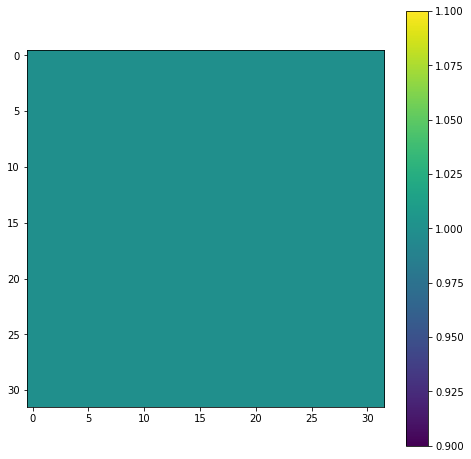

In [12]:
centre = (0,0,0)
#radius = 0.07 # for nx=64
#radius = 0.14 # for nx=128
radius = 0.28 # for nx=256

mask = create_3d_mask(x_grid, centre, radius)


mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

### Forward model and loss functon

In [13]:
alpha = 0.1

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)

grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

Test the functions above with a random volume

In [14]:
vf = jnp.array(np.random.randn(nx,nx,nx))
sf = slice_func(vf, angles[0], shifts[0], ctf_params[0])
sf.shape

(1024,)

In [15]:
start = time.time()
ll = grad_loss_volume(vf, angles[0], shifts[0], ctf_params[0], imgs_f[0])
print(time.time()-start)
print(ll.shape)

1.7411673069000244
(32, 32, 32)


In [16]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(vf, angles[idx], shifts[idx], ctf_params[idx], imgs_f[idx])
print(time.time()-start)
print(ll.shape)

1.8755784034729004
(32, 32, 32)


### Ab initio

In [17]:
x_grid[0]*x_grid[1]/2

0.05021972132474

In [18]:
x_grid[0]

0.00313873258279625

1e-06
1.000001
1e-06


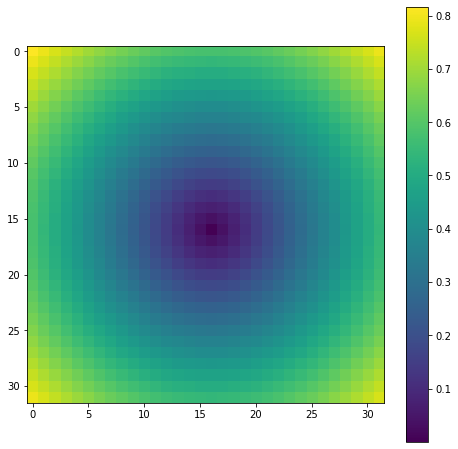

In [19]:
P = get_preconditioner(x_grid) * mask
#P = jnp.sqrt(P) /jnp.max(P) + 1e-6
P = jnp.sqrt(P)
P = P /jnp.max(P)+ 1e-6
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

In [20]:
#angles_rec0 = angles_rec
#v_rec0 = v_rec

  sgd epoch 0: mean full gradient = 4.776900268339607e-05
  sgd epoch 50: mean full gradient = 5.780753594645999e-06
  sgd epoch 100: mean full gradient = 1.9600543445361296e-06
  sgd epoch 150: mean full gradient = 4.831532709791079e-06
  sgd epoch 200: mean full gradient = 1.541657182350794e-06


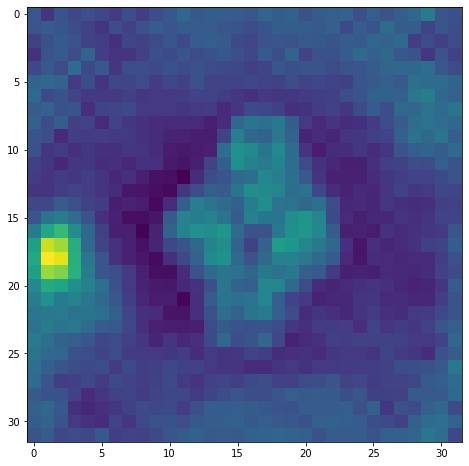

Iter  0
  Time orientations sampling = 1.9662840366363525


In [ ]:
N_samples = 100000
N_iter = 100

dr = 0.005
radius = 0.01
#radius = 0.03
alpha = 1e-6
#alpha = 0.1

use_sgd = True

N_cg_iter = 201

N_sgd_iter = 201
batch_size = 300
#learning_rate = 1000
learning_rate = 10000
#P = None

if use_sgd:
    N_vol_iter = N_sgd_iter
else:
    N_vol_iter = N_cg_iter

out_dir = '../data/relion/'
imgs_f = imgs_f.reshape([N, nx*nx])

v_rec, angles_rec = ab_initio(angles_rec0, project, imgs_f, shifts, ctf_params, x_grid, use_sgd, N_iter, N_vol_iter, learning_rate, batch_size, P, N_samples, radius, dr, alpha, 'tri', True, True, True, out_dir)

In [251]:
v_rec.shape

(32, 32, 32)

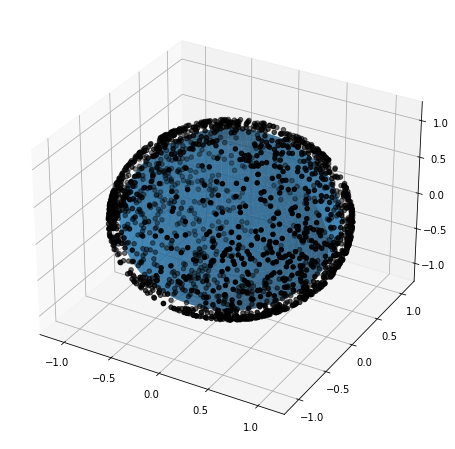

In [252]:
plot_angles(angles_rec[:2000])

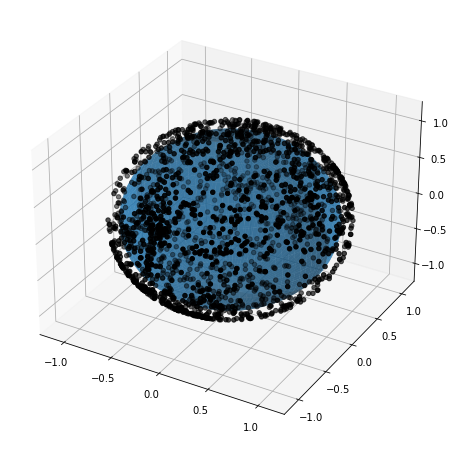

In [24]:
plot_angles(angles_rec[:2000])

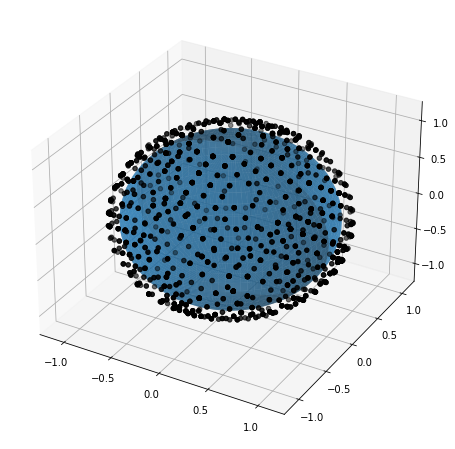

In [30]:
plot_angles(angles[:2000])

### CG

In [36]:
alpha = 1e-6 #0.1

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)

grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

In [26]:
#v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
v0 = jnp.zeros([nx,nx,nx])* 1j
N_iter = 251

#N2 = jnp.floor(N/2).astype(jnp.int64)
N2 = 10000
AA1, Ab1 = get_cg_vol_ops(grad_loss_volume_sum, angles_rec[:N2], shifts[:N2], ctf_params[:N2], imgs_f[:N2], v0.shape)

In [149]:
vcg1, _ = conjugate_gradient(AA1, Ab1, v0, N_iter, verbose = True)

  cg iter 0 ||r|| = 0.050562101653577184
  cg iter 50 ||r|| = 5.477129065433209e-05
  cg iter 100 ||r|| = 1.1256315992108184e-05
  cg iter 150 ||r|| = 1.1537550624178641e-05
  cg iter 200 ||r|| = 9.360096860650594e-06
  cg iter 250 ||r|| = 2.2480983347696265e-05


In [150]:
sgd_loss_func(vcg1, jnp.arange(N))

DeviceArray(114869.42706103, dtype=float64)

In [127]:
#AA2, Ab2 = get_cg_vol_ops(grad_loss_volume_sum, angles[N2:], shifts[N2:], ctf_params[N2:], imgs_f[N2:], v0.shape)

#vcg2, _ = conjugate_gradient(AA1, Ab1, vcg1, 100, verbose = True)

In [128]:
i = 110
s0 = slice_func(v_rec, angles_rec[i], shifts[i], ctf_params[i])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

NameError: name 'v_rec' is not defined

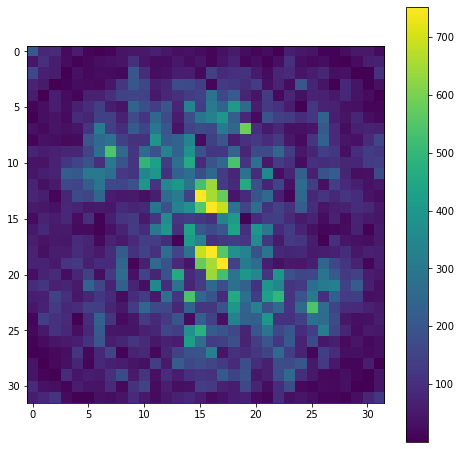

In [129]:
i = 110
s0 = slice_func(vcg1, angles_rec[i], shifts[i], ctf_params[i])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

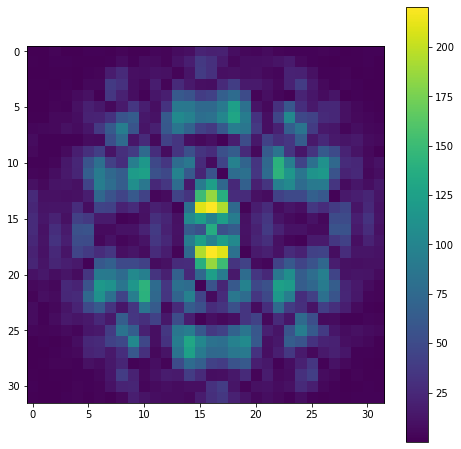

In [151]:
plt.imshow(jnp.fft.fftshift(jnp.abs(vcg1[:,0,:]))); plt.colorbar()

In [131]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec))))
plt.colorbar()
plt.title('Reconstruction MIP')

NameError: name 'v_rec' is not defined

Text(0.5, 1.0, 'Reconstruction MIP')

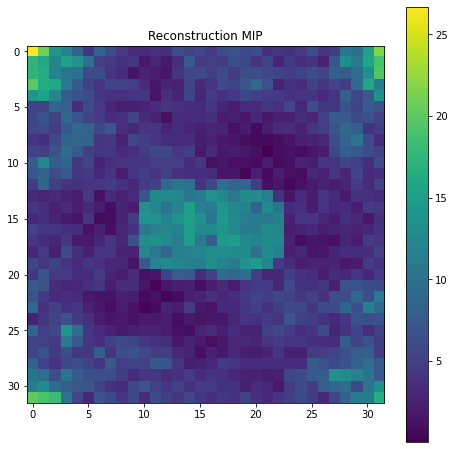

In [132]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))))
plt.colorbar()
plt.title('Reconstruction MIP')

In [133]:
vr1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))) 

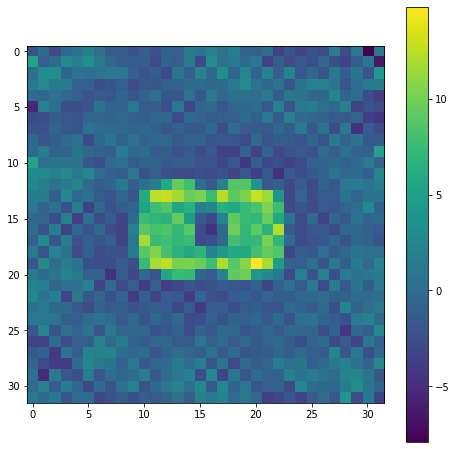

In [134]:
plt.imshow(vr1[:,:,16]); plt.colorbar()

### Write volume to file

In [135]:
with mrcfile.new('../data/reconstruction_data_32_cg_angles_rec.mrc', overwrite=True) as mrc:
    mrc.set_data(vr1.astype(np.float32))

### FSC, orientations, standard deviation for each voxel etc

In [29]:
vcg2=vcg1

In [30]:
#dr = 0.01
dr = 0.05
res, fsc, shell_points = calc_fsc(vcg1, vcg2, x_grid, dr)


In [43]:
#points_v_tri = points_orientations_tri(angles[:50], x_grid[1])
points_v_nn = points_orientations_nn(angles[:1000], x_grid[1])

In [ ]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid, dr = 0.05)

In [ ]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
#plt.title('Clustered angles')

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[0,:,:]*mask[0,:,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,0,:]*mask[:,0,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,:,0]*mask[:,:,0]))))); plt.colorbar()

In [ ]:
vones = jnp.ones(vcg1.shape)
omega = AA1(vones)
omega = 1/omega

In [ ]:
plt.title("Standard deviation")
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[:,0,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[:,:,0]))))); plt.colorbar()

### SGD

### Preconditioner

0.5011371424499267
1.0
0.5011371424499267


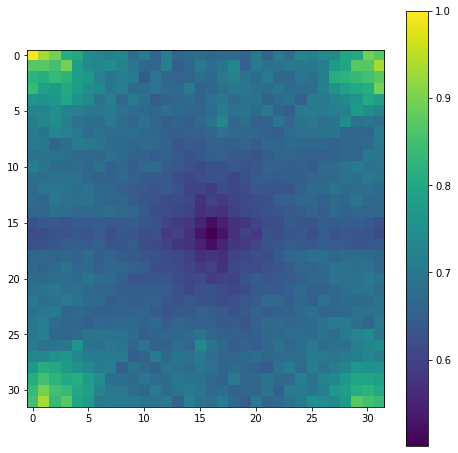

In [54]:
points_v_nn.shape
P2 = points_v_nn
P2 += 1
P2 = (1/P2**0.1 ) * mask

P2 = P2/jnp.max(P2)

plt.imshow(jnp.fft.fftshift(P2[:,:,0]));plt.colorbar()
print(P2[0,0,0])
print(jnp.max(P2))
print(jnp.min(P2))

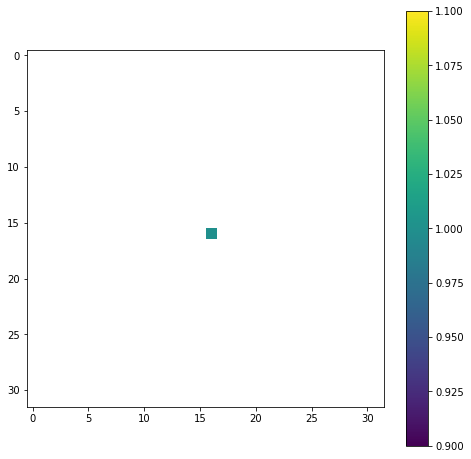

In [103]:
from src.utils import get_sinc

S = get_sinc(x_grid)
plt.imshow(jnp.fft.fftshift(S[:,:,0]));plt.colorbar()



1e-06
1.000001
1e-06


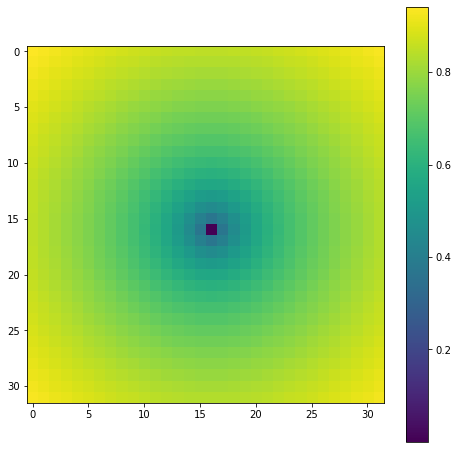

In [22]:
P = get_preconditioner(x_grid) * mask
#P = jnp.sqrt(P) /jnp.max(P) + 1e-6
#P = jnp.sqrt(P)
P = P**0.15
P = P /jnp.max(P)+ 1e-6
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

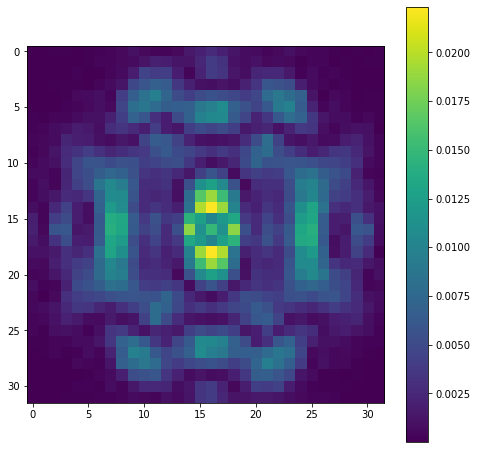

In [38]:
g = sgd_grad_func(v0, jnp.arange(N))
plt.imshow(jnp.fft.fftshift(jnp.abs(g[:,:,0]))) ; plt.colorbar()

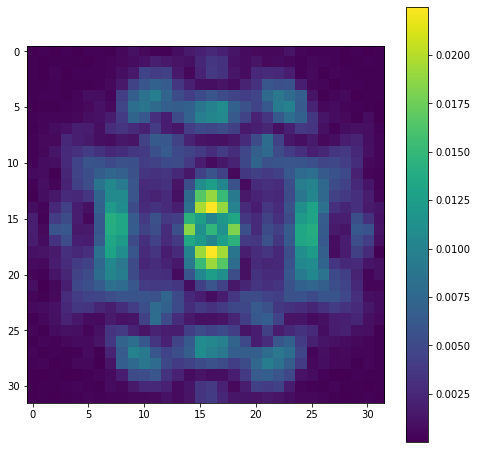

In [33]:
g = sgd_grad_func(v0, jnp.arange(N))
plt.imshow(jnp.fft.fftshift(jnp.abs(g[:,:,0]))) ; plt.colorbar()

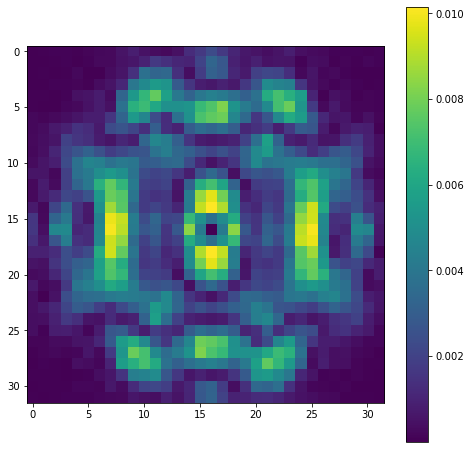

In [39]:
gp = g * P
plt.imshow(jnp.fft.fftshift(jnp.abs(gp[:,:,0]))) ; plt.colorbar()

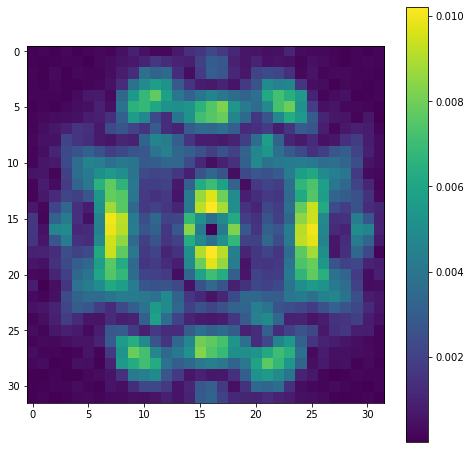

In [35]:
gp = g * P
plt.imshow(jnp.fft.fftshift(jnp.abs(gp[:,:,0]))) ; plt.colorbar()


In [37]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
#v0 = jnp.zeros([nx,nx,nx])* 1j

batch_size = 200
N_epoch = 151
number_of_batches = N/batch_size
learning_rate = 10000
#learning_rate = 10000 # <- with normalized precon
#P = None

sgd_grad_func, sgd_loss_func = get_sgd_vol_ops(grad_loss_volume_batched, loss_func_sum, angles_rec, shifts, ctf_params, imgs_f)

In [ ]:
vgd = sgd(sgd_grad_func, N, v0, learning_rate, N_epoch, batch_size, P, True, sgd_loss_func)
            
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(vgd, angles_rec, shifts, ctf_params, imgs_f)))
print("Relative error with CG = ", jnp.max(jnp.abs((vgd - vcg1)/jnp.max(vcg1))))

In [161]:
imgs_f.shape

(4501, 1024)

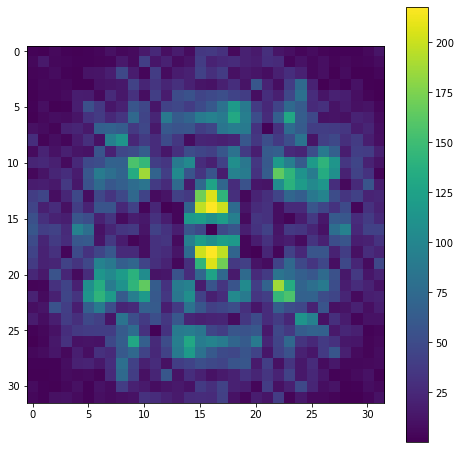

In [162]:
plt.imshow(jnp.fft.fftshift(jnp.abs(vgd[:,0,:]))); plt.colorbar()

In [91]:
plt.imshow(jnp.fft.fftshift(jnp.abs(v_rec[:,0,:]))); plt.colorbar()

NameError: name 'v_rec' is not defined

In [155]:
vr_sgd = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vgd)))

Text(0.5, 1.0, 'Reconstruction MIP')

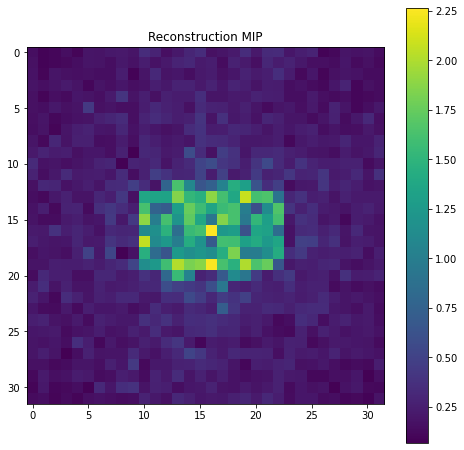

In [156]:
mip_z(vr_sgd)
plt.colorbar()
plt.title('Reconstruction MIP')

In [95]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title('Reconstruction MIP')

NameError: name 'v_rec' is not defined

In [96]:
with mrcfile.new('../data/reconstruction_data_32_sgd_angles_rec.mrc', overwrite=True) as mrc:
    mrc.set_data(vr_sgd.astype(np.float32))